## AISE4010- Project - Traffic Congestion

### Group 7:
#### Aaron Triguero, Khen Agnes, Shiv Pi Patel



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model

## View raw files for speed, occupancy, travel time

                     Occupancy
timestamp                     
2015-09-01 11:30:00      13.56
2015-09-01 11:35:00       8.33
2015-09-01 11:40:00      11.78
2015-09-01 11:55:00      15.28
2015-09-01 12:00:00      10.06


<Axes: xlabel='timestamp', ylabel='average # cars'>

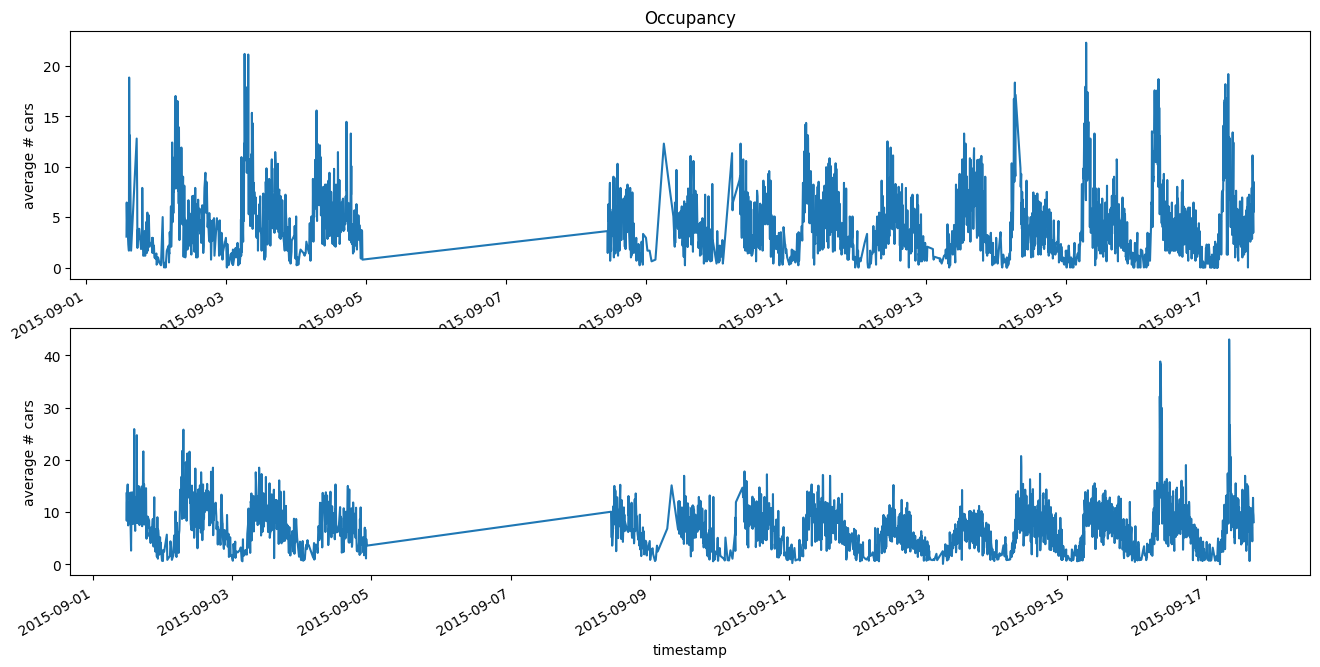

In [15]:
# Load Occupancy dataset
df_o1 = pd.read_csv('occupancy_6005.csv').rename(columns={'value':'Occupancy'})
df_o2 = pd.read_csv('occupancy_t4013.csv').rename(columns={'value':'Occupancy'})

# Set index
df_o1['timestamp'] = pd.to_datetime(df_o1['timestamp'])   # to datetime
df_o2['timestamp'] = pd.to_datetime(df_o2['timestamp'])
df_o1 = df_o1.set_index('timestamp')
df_o2 = df_o2.set_index('timestamp')
print(df_o2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_o1['Occupancy'].plot(ylabel='average # cars',title='Occupancy')
plt.subplot(2, 1, 2)
df_o2['Occupancy'].plot(ylabel='average # cars')

                     Travel Time
timestamp                       
2015-07-28 11:56:00          248
2015-07-28 12:06:00          178
2015-07-28 12:25:00          155
2015-07-28 13:56:00          121
2015-07-28 14:06:00          103


<Axes: xlabel='timestamp', ylabel='seconds'>

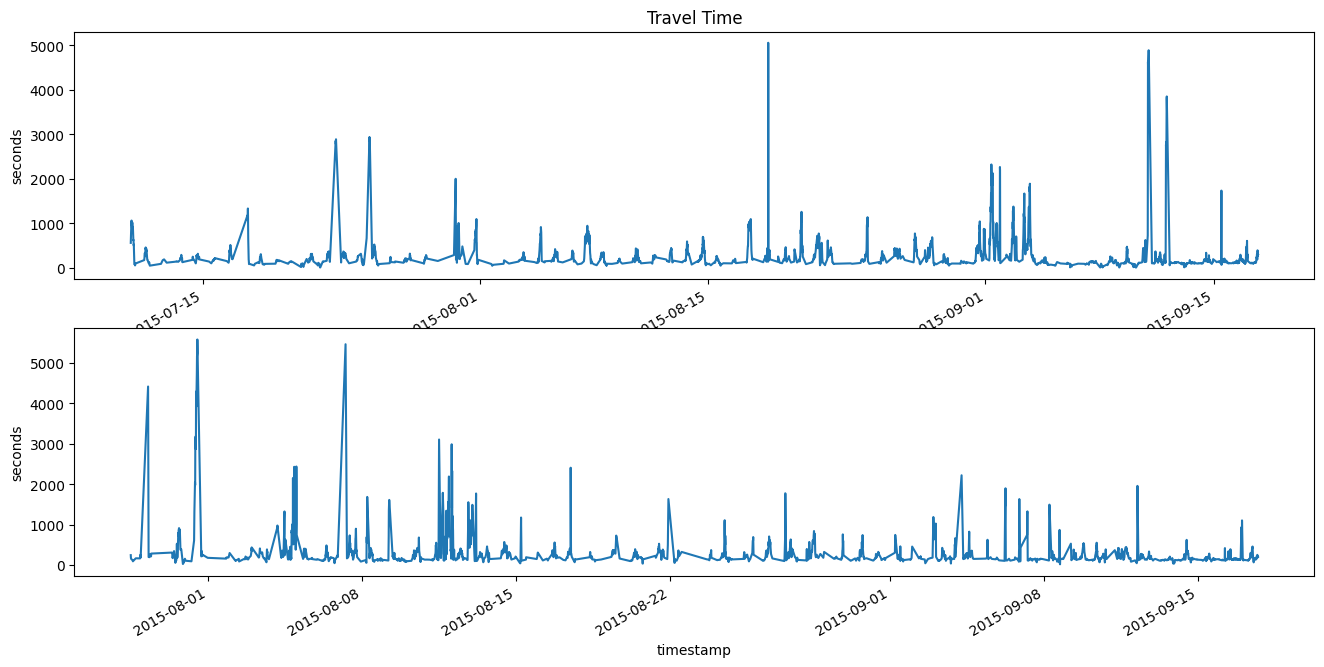

In [16]:
# Load TravelTime dataset
df_t1 = pd.read_csv('TravelTime_387.csv').rename(columns={'value':'Travel Time'})
df_t2 = pd.read_csv('TravelTime_451.csv').rename(columns={'value':'Travel Time'})

# Set index
df_t1['timestamp'] = pd.to_datetime(df_t1['timestamp'])   # to datetime
df_t2['timestamp'] = pd.to_datetime(df_t2['timestamp'])
df_t1 = df_t1.set_index('timestamp')
df_t2 = df_t2.set_index('timestamp')
print(df_t2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_t1['Travel Time'].plot(ylabel='seconds',title='Travel Time')
plt.subplot(2, 1, 2)
df_t2['Travel Time'].plot(ylabel='seconds')

                     Speed
timestamp                 
2015-09-01 11:25:00     58
2015-09-01 11:30:00     63
2015-09-01 11:35:00     63
2015-09-01 11:40:00     64
2015-09-01 11:55:00     58


<Axes: xlabel='timestamp', ylabel='km/h'>

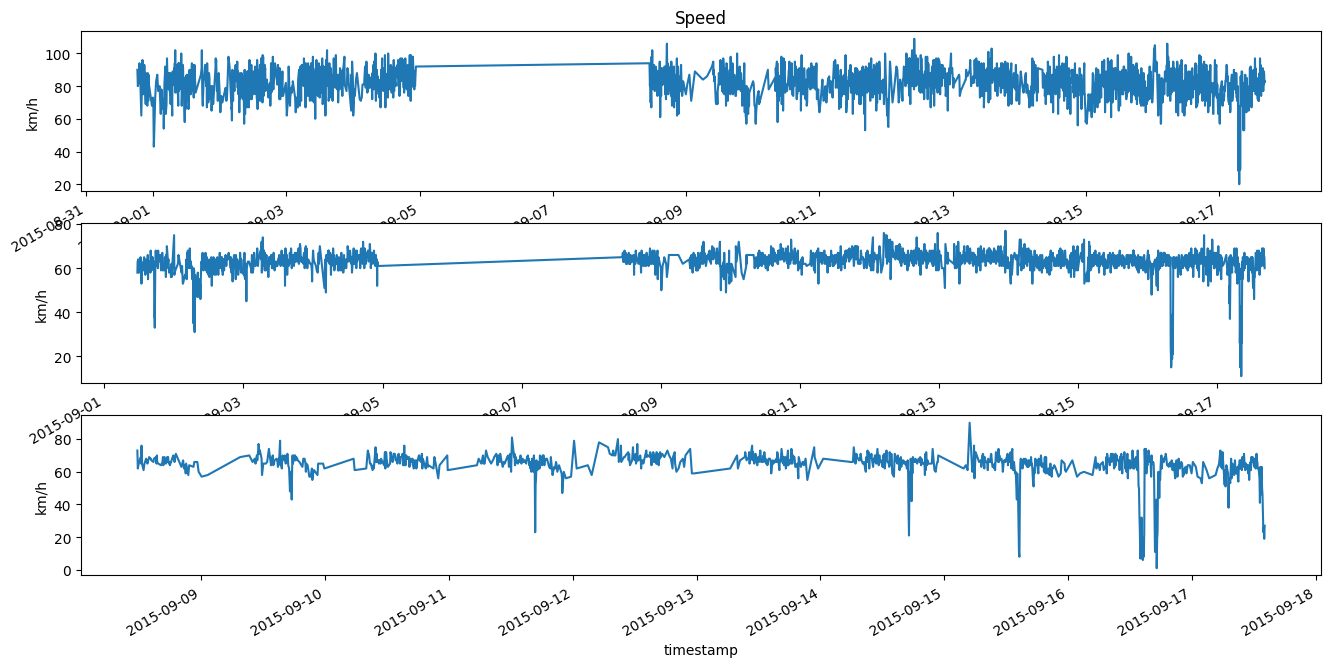

In [17]:
# Load speed dataset
df_s1 = pd.read_csv('speed_6005.csv').rename(columns={'value':'Speed'})
df_s2 = pd.read_csv('speed_t4013.csv').rename(columns={'value':'Speed'})
df_s3 = pd.read_csv('speed_7578.csv').rename(columns={'value':'Speed'})

# Set index
df_s1['timestamp'] = pd.to_datetime(df_s1['timestamp'])   # to datetime
df_s2['timestamp'] = pd.to_datetime(df_s2['timestamp'])
df_s3['timestamp'] = pd.to_datetime(df_s3['timestamp'])
df_s1 = df_s1.set_index('timestamp')
df_s2 = df_s2.set_index('timestamp')
df_s3 = df_s3.set_index('timestamp')
print(df_s2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(3, 1, 1)
df_s1['Speed'].plot(ylabel='km/h',title='Speed')
plt.subplot(3, 1, 2)
df_s2['Speed'].plot(ylabel='km/h')
plt.subplot(3, 1, 3)
df_s3['Speed'].plot(ylabel='km/h')

## 1. Form Dataset and Preprocess

- notice preprocess choices made, such as resampling

#### Joining, Resampling and Normalizing

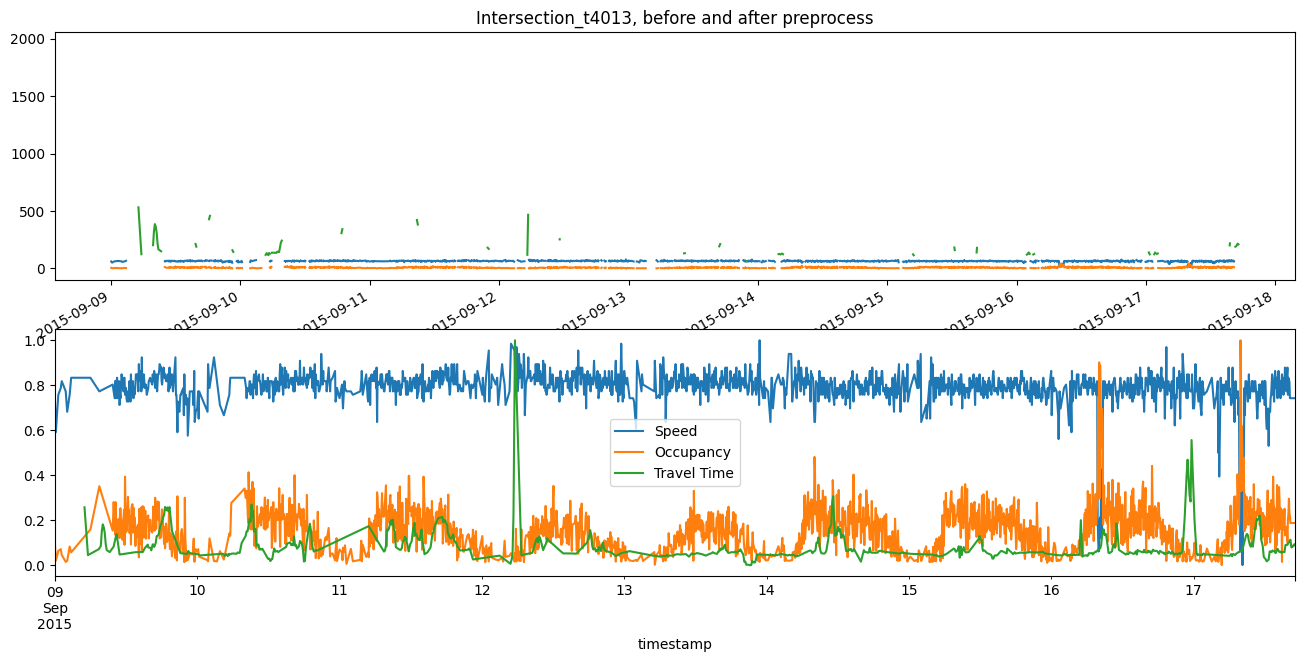

In [18]:
# Dataset for intersection 6005
# data_6005 = df_o1.join(df_t1, how='outer').join(df_s1, how='outer')
# data_6005 = data_6005['2015-09-09':]  # take only data after certain date             # if we wanted to do 2 intersections

# Dataset for intersection t4013
data_t4013 = df_o2.join(df_t2, how='outer').join(df_s2, how='outer')
data = data_t4013['2015-09-09':]  # take only data after certain date



# Plot data before resampling
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
data['Speed'].plot(title='Intersection_t4013, before and after preprocess')#, ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()


# Data after resampling (using mean) to 5 min intervals
# and handling missing data using _______(interpolation)________
data = data.resample('5min').mean()
data = data.interpolate()

# Normalize each variable using ________(MinMax)_________
scaler = MinMaxScaler()
data['Speed'] = scaler.fit_transform(data[['Speed']])
data['Occupancy'] = scaler.fit_transform(data[['Occupancy']])
data['Travel Time'] = scaler.fit_transform(data[['Travel Time']])


# Plot data after preprocessing
plt.subplot(2,1,2)
data['Speed'].plot()#ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()
plt.legend()
plt.show()


In [19]:
data.shape    # (2510 timesteps, 3 variables)

(2510, 3)

#### Components of the time series

In [20]:
# check seasonality, trends, etc for each variable

#### Splitting train and test sets

In [21]:
# Sliding window to split data

def sliding_window(data, n):
    # data: original data
    # n: window size
    X, y = [], []
    for i in range(len(data) - n):
        X.append(data[i:(i + n)])
        y.append(data[i + n])
    return np.array(X), np.array(y)


# For n timesteps
n_steps = 12      # each 60 minutes (5 minutes per timestep)

# Each variable
Xo, yo = sliding_window(data['Occupancy'], n_steps)
Xs, ys = sliding_window(data['Speed'], n_steps)
Xt, yt = sliding_window(data['Travel Time'], n_steps)

# Split data into training testing sets
split = int(len(Xo)*0.8)

Xo_train, Xo_test = Xo[:split], Xo[split:]
yo_train, yo_test = yo[:split], yo[split:]

Xs_train, Xs_test = Xs[:split], Xs[split:]
ys_train, ys_test = ys[:split], ys[split:]

Xt_train, Xt_test = Xt[:split], Xt[split:]
yt_train, yt_test = yt[:split], yt[split:]

# Reshape
Xo_train = Xo_train.reshape(Xo_train.shape[0], Xo_train.shape[1], 1)
Xo_test = Xo_test.reshape(Xo_test.shape[0], Xo_test.shape[1], 1)

Xs_train = Xs_train.reshape(Xs_train.shape[0], Xs_train.shape[1], 1)
Xs_test = Xs_test.reshape(Xs_test.shape[0], Xs_test.shape[1], 1)

Xt_train = Xt_train.reshape(Xt_train.shape[0], Xt_train.shape[1], 1)
Xt_test = Xt_test.reshape(Xt_test.shape[0], Xt_test.shape[1], 1)


/tmp/ipykernel_3619/4273797092.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + n])


## 2. Models, Training

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model

from time import time

### CNN Model

In [23]:
# create models
# CNN model
model_CNN = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(Xo_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Optimizer ________ and loss _________
model_CNN.compile(optimizer='adam', loss='mean_squared_error')    # why?

model_CNN_s, model_CNN_o, model_CNN_t= model_CNN, model_CNN, model_CNN

# Choose parameters and train dataset
EPOCHS = 50
BATCH_SIZE = 32



#### Training using CNN models

Epoch 1/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0716 - val_loss: 0.0024
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0027
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0020
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0176 - val_loss: 0.0026
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0020
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0176 - val_loss: 0.0037
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0174 - val_loss: 0.0020
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0164 - val_loss: 0.0020
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0019
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0157 - val_loss: 0.0019
Epoch 11/50
50/50 

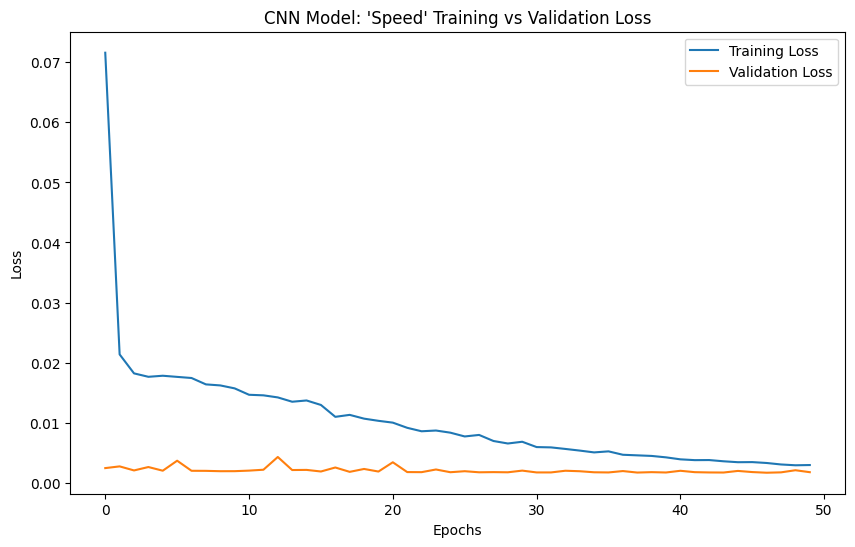

CNN Training Time for 'Speed': 13.929 seconds


In [24]:
# Speed data
start_time = time()
cnn_history_speed = model_CNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)
cnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_speed.history['loss'], label='Training Loss')
plt.plot(cnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Speed\': {cnn_time_speed:.3f} seconds")

Epoch 1/50
 1/50 [..............................] - ETA: 0s - loss: 0.2396

50/50 [==============================] - 0s 5ms/step - loss: 0.0483 - val_loss: 0.0043
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0036
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 6/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0035
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0044
Epoch 8/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 11/50
50/50 [===========

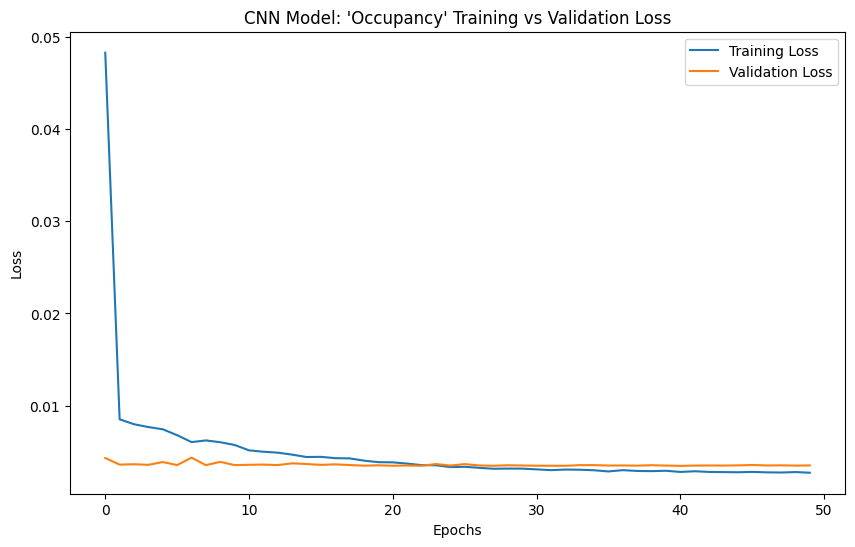

CNN Training Time for 'Occupancy': 14.663 seconds


In [25]:
# Occupancy data
start_time = time()
cnn_history_occupancy = model_CNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)
cnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(cnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Occupancy\': {cnn_time_occupancy:.3f} seconds")

Epoch 1/50
13/50 [======>.......................] - ETA: 0s - loss: nan   

50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 11/50
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: n

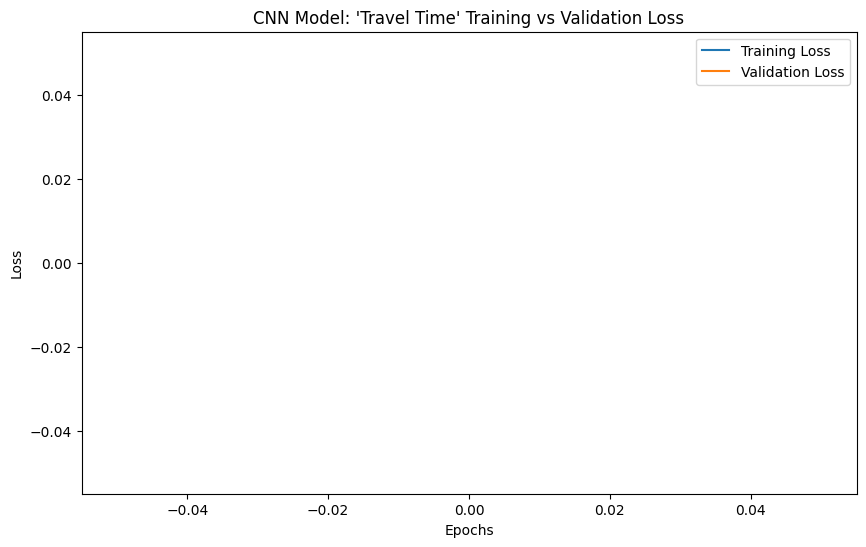

CNN Training Time for 'Travel Time': 13.130 seconds


In [26]:
# Travel Time data
start_time = time()
cnn_history_ttime = model_CNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)
cnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(cnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Travel Time\': {cnn_time_ttime:.3f} seconds")